# Prostate Cancer
The data for this example, displayed in Figure 1.11, come from a study by Stamey et al. (1989) that examined the correlation between the level of prostate specific antigen (PSA) and a number of clinical measures, in 97 men who were about to receive a radical prostatectomy.

The goal is to predict the log of PSA (lpsa) from a number of measurements including log cancer volume (lcavol), log prostate weight lweight, age, log of benign prostatic hyperplasia amount lbph, seminal vesicle invasion svi, log of capsular penetration lcp, Gleason score gleason, and percent of Gleason scores 4 or 5 pgg45. Figure 1.1 is a scatterplot matrix of the variables. Some correlations with lpsa are evident, but a good predictive model is difficult to construct by eye.

This is a supervised learning problem, known as a regression problem, because the outcome measurement is quantitative. (PAGE 3)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# load training and test data set from file
df = pd.read_csv("../data/Prostate Cancer.txt")
target = ['lpsa']
features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']

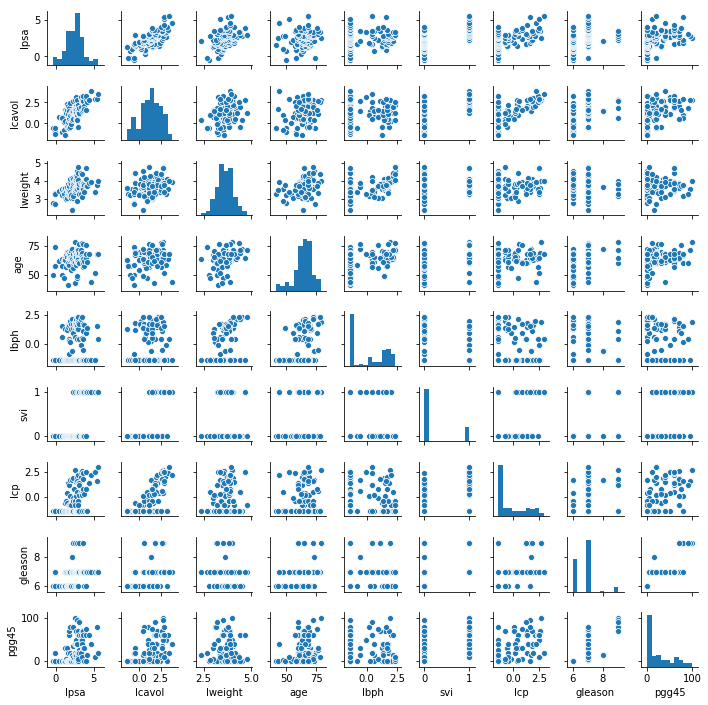

In [3]:
# PAGE 3. FIGURE 1.1. Scatterplot matrix of the prostate cancer data. The first row shows
#         the response against each of the predictors in turn. Two of the predictors, svi and
#         gleason, are categorical.
sns.pairplot(df, vars=target+features, kind="scatter", height=1.1)

In [4]:
# split data to training/test np.arrays
df_train = df[df.train == 'T']
df_test = df[df.train == 'F']
X_train, y_train = df_train[features].values, df_train[target].values
X_test, y_test = df_test[features].values, df_test[target].values
y_test_flat = np.squeeze(y_test)
N_test = y_test_flat.shape[0]

In [5]:
# PAGE 49. The correlation matrix of the predictors given in Table 3.1 shows many
#          strong correlations. Figure 1.1 (page 3) of Chapter 1 is a scatterplot matrix
#          showing every pairwise plot between the variables. We see that svi is a
#          binary variable, and gleason is an ordered categorical variable. We see, for
#          example, that both lcavol and lcp show a strong relationship with the
#          response lpsa, and with each other. We need to fit the effects jointly to
#          untangle the relationships between the predictors and the response.
df[df.train == 'T'][features].corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


## Base Error Rate

In [6]:
# PAGE 51. prediction using the mean training value of lpsa has
#          a test error of 1.057, which is called the "base error rate".
base_error_rate = mean_squared_error(y_test, np.full(y_test.shape, np.mean(y_train)))
print(f'Baseline Test Error: {base_error_rate:.3f}')

Baseline Test Error: 1.057


## Least Squares

In [7]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

C:\Python64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
# PAGE 50. We fit a linear model to the log of prostate-specific antigen, lpsa, after
#          first standardizing the predictors to have unit variance.
scaler = StandardScaler().fit(np.vstack([X_train, X_test]))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# PAGE 50. We applied least squares estimation to the training set, producing the estimates,
#          standard errors and Z-scores shown in Table 3.2. 
ls = sm.OLS(y_train, sm.add_constant(X_train)).fit()
ls_params = ls.params

# PAGE 50.   TABLE 3.2. Linear model fit to the prostate cancer data. The Z score (t value) is the
#            coefficient divided by its standard error (3.12). Roughly Z score larger than two 
#            in absolute value is significantly nonzero at the p = 0.05 level.
result = zip(['Intercept'] + features, ls_params, ls.bse, ls.tvalues)
print('      Term   Coefficient   Std. Error   Z Score')
print('-----------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>10}   {coefficient:>11.2f}   {std_err:>10.2f}  {z_score:>8.2f}')

      Term   Coefficient   Std. Error   Z Score
-----------------------------------------------
 Intercept          2.46         0.09     27.60
    lcavol          0.68         0.13      5.37
   lweight          0.26         0.10      2.75
       age         -0.14         0.10     -1.40
      lbph          0.21         0.10      2.06
       svi          0.30         0.12      2.47
       lcp         -0.29         0.15     -1.87
   gleason         -0.02         0.14     -0.15
     pgg45          0.27         0.15      1.74


In [10]:
# PAGE 51. The mean prediction error on the test data is 0.521.
y_hat = ls.predict(sm.add_constant(X_test))
ls_error_rate = mean_squared_error(y_test_flat, y_hat)
ls_std_error = np.std((y_test_flat - y_hat)**2, ddof=1)/np.sqrt(N_test)
print(f'Least Squares Test Error: {ls_error_rate:.3f}')
print(f'               Std Error: {ls_std_error:.3f}')

Least Squares Test Error: 0.521
               Std Error: 0.179


## Cross-Validation

In [11]:
from sklearn.model_selection import GridSearchCV, KFold

# PAGE 62. The estimates of prediction error and their standard errors were obtained by
#          tenfold cross-validation; full details are given in Section 7.10.

# with this random state value, our CV results are close to the book's result
rs, K = 69438, 10

# let's write a common function for doing cross-validation
def do_cross_validation(estimator, param_grid):
    # prepare grid search object with 10-fold cross validation
    # it uses neg_mean_squared_error due to the higher is the better approach
    grid_search = GridSearchCV(estimator, param_grid, 
                               cv=KFold(K, True, rs), 
                               scoring='neg_mean_squared_error',
                               return_train_score=True,
                               iid=True)
    grid_search.fit(X_train, y_train)
    
    # convert neg_mean_squared_error to mean squared error and 
    # reshape results to the form where a row correspons to one paramenter's 10
    # cross validation mse values
    cv_erros = -np.vstack([grid_search.cv_results_[f'split{i}_test_score'] 
                           for i in range(K)]).T
    # calculate mean squared error for parameters and their standard error
    cv_mean_errors = np.mean(cv_erros, axis=1)
    cv_std_errors = np.std(cv_erros, ddof=1, axis=1)/np.sqrt(K)
    
    # PAGE 62. The least complex model within one standard error of the best is chosen
    best_index = np.argmin(cv_mean_errors)
    best_err, best_std_err = cv_mean_errors[best_index], cv_std_errors[best_index]
    selected_model_index = np.argmax(cv_mean_errors < (best_err + best_std_err))
    
    return cv_mean_errors, cv_std_errors, best_err, best_std_err, selected_model_index

# calculates the estimator's test mean squared error and its standard error
def assess_selected_model(estimator):
    # different models return predictions in different shapes, so let's squeeze y-hat
    y_hat = np.squeeze(estimator.predict(X_test))
    error_rate = mean_squared_error(y_test_flat, y_hat)
    std_error = np.std((y_test_flat - y_hat)**2, ddof=1)/np.sqrt(N_test)    
    return error_rate, std_error

## Plotting

In [12]:
# PAGE 62. FIGURE 3.7. Estimated prediction error curves and their standard errors for
#          the various selection and shrinkage methods. Each curve is plotted as a function
#          of the corresponding complexity parameter for that method. The horizontal axis
#          has been chosen so that the model complexity increases as we move from left to
#          right. The estimates of prediction error and their standard errors were obtained by
#          tenfold cross-validation; full details are given in Section 7.10. The least complex
#          model within one standard error of the best is chosen, indicated by the purple
#          vertical broken lines.

# let's write a common plotting function for FIGURE 3.7
ORANGE, BLUE, PURPLE, GRAY1, GRAY4 = '#E69F00', '#56B4E9', '#A020F0', '#231F20', '#646369'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
def plot_cv_results(title, x_label,
                    test_error, std_error,
                    complexity_vals,
                    cv_mean_errors, cv_std_errors,
                    best_err, best_std_err, 
                    selected_model_index):
    fig, ax1 = plt.subplots(figsize=(4, 3.1), dpi=110)
    ax1.plot(complexity_vals, cv_mean_errors, 
             c=ORANGE, linewidth=0.8)
    ax1.errorbar(complexity_vals, cv_mean_errors,
                 color=ORANGE, linestyle='None', marker='o', elinewidth=0.8,
                 markersize=3, yerr=cv_std_errors, ecolor=BLUE, capsize=3)
    ax1.axhline(y=best_err+best_std_err, c=PURPLE, linewidth=0.8, linestyle='--')
    ax1.axvline(x=complexity_vals[selected_model_index], 
                c=PURPLE, linewidth=0.8, linestyle='--')    
    for i in ax1.get_yticklabels() + ax1.get_xticklabels():
        i.set_fontsize(6)    
    ax1.text(ax1.get_xlim()[0], 1.85, title, color=GRAY4, fontsize=9)
    ax1.set_xlabel(x_label, color=GRAY4, fontsize=8)
    ax1.set_ylabel('CV Error', color=GRAY4, fontsize=8)    
    parms = {'color': GRAY1, 'fontsize': 7,
             'bbox': {'facecolor': 'white', 'pad': 0, 'edgecolor': 'none'}}
    lim = ax1.get_xlim()
    text_x = lim[1] - (lim[1]-lim[0])*0.02
    ax1.text(text_x, 1.72, f'Test Error:  {test_error:.3f}', **parms, ha='right')
    ax1.text(text_x, 1.63, f' Std Error:  {std_error:.3f}', **parms, ha='right')    

## Ridge Regression

In [13]:
# PAGE 61. Ridge regression shrinks the regression coefficients by imposing a penalty
#          on their size. The ridge coefficients minimize a penalized residual sum of
#          squares, (3.41)
#          Here λ ≥ 0 is a complexity parameter that controls the amount of shrinkage: 
#          the larger the value of λ, the greater the amount of shrinkage. The
#          coefficients are shrunk toward zero (and each other). The idea of penalizing 
#          by the sum-of-squares of the parameters is also used in neural networks,
#          where it is known as weight decay (Chapter 11).
from sklearn.linear_model import Ridge

In [14]:
degress_of_freedom = list(range(9))
# these alpha parameters correspond to 0-8 degrees of freedom
parameters = {'alpha': [1e20, 436, 165, 82, 44, 27, 12, 4, 1e-05]}
# run CV to chose best parameter
rd_errs, rd_std_errs, best_err, best_std_err, selected_index = \
    do_cross_validation(Ridge(), parameters)

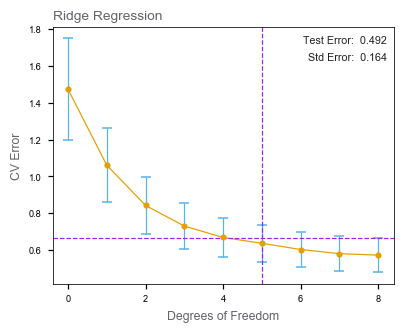

In [15]:
# refit the model to the training set with alpha from CV
rd = Ridge(alpha=parameters['alpha'][selected_index]).fit(X_train, y_train)
# save model parameters as 1D vector
rd_params = np.hstack((rd.intercept_, np.squeeze(rd.coef_)))
# estimate Test Error and Std Error
rd_error_rate, rd_std_error = assess_selected_model(rd)
# plot results
plot_cv_results('Ridge Regression', 'Degrees of Freedom',
                rd_error_rate, rd_std_error,
                degress_of_freedom, rd_errs, rd_std_errs,
                best_err, best_std_err, selected_index)

## Lasso Regression

In [16]:
# PAGE 68. The lasso is a shrinkage method like ridge, with subtle but important 
#          differences. The lasso estimate is defined by (3.51).
from sklearn.linear_model import Lasso

In [17]:
shrinkage = [0, 0.102, 0.254, 0.384, 0.504, 0.612, 0.756, 0.883, 1]
# these alpha parameters correspond to above shrinkage values
parameters = {'alpha': [1, 0.680, 0.380, 0.209, 0.100, 0.044, 0.027, 0.012, 0.001]}
# run CV to chose best parameter
lo_errs, lo_std_errs, best_err, best_std_err, selected_index = \
    do_cross_validation(Lasso(), parameters)

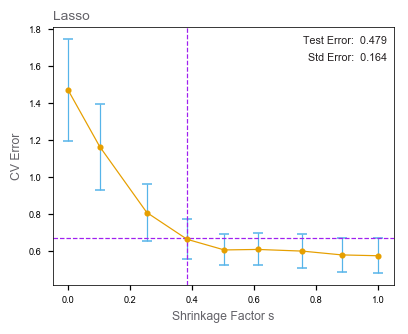

In [18]:
# refit the model to the training set with alpha from CV
lo = Lasso(alpha=parameters['alpha'][selected_index]).fit(X_train, y_train)
# save model parameters as 1D vector
lo_params = np.hstack((lo.intercept_, np.squeeze(lo.coef_)))
# estimate Test Error and Std Error
lo_error_rate, lo_std_error = assess_selected_model(lo)
# plot results
plot_cv_results('Lasso', 'Shrinkage Factor s',
                lo_error_rate, lo_std_error,
                shrinkage, lo_errs, lo_std_errs,
                best_err, best_std_err, selected_index)

## Principal Components Regression

In [19]:
# PAGE 79. In this approach the linear combinations Zm used are the principal 
#          components as defined in Section 3.4.1 above.
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [20]:
n_directions = list(range(0, 9))
# it is not possible to use PCA with 0 directions, so run CV with 1-8 directions
parameters = {'pca__n_components': list(range(1, 9))}
model = Pipeline([('pca', PCA()),
                  ('regression', LinearRegression())])
# run CV to chose best parameter
pc_errs, pc_std_errs, best_err, best_std_err, selected_index = \
    do_cross_validation(model, parameters)

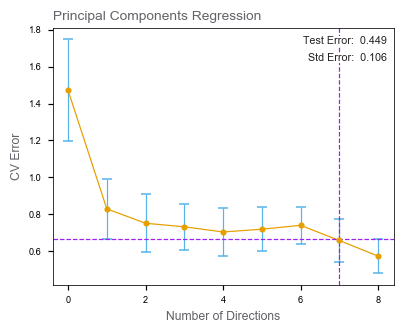

In [21]:
# refit the model to the training set with n-directions from CV
pca = PCA(n_components=parameters['pca__n_components'][selected_index])
lr = LinearRegression()
model = Pipeline([('pca', pca),
                  ('regression', lr)]).fit(X_train, y_train)

# X_train are not centered, so calculation is little bit different
pc_params = np.zeros(8)
intercept = lr.intercept_[0]
for i in range(7):
    pc_params += lr.coef_[0, i]*pca.components_[i, :]
    intercept -= lr.coef_[0, i]*(pca.mean_ @ pca.components_[i, :])

# the parameters are different from the book, but are correct
pc_params = np.hstack(([intercept], pc_params))

# estimate Test Error and Std Error
pc_error_rate, pc_std_error = assess_selected_model(model)
# it is not possible to calculate err & std err for n = 0 directions
# so copy it from lasso results, because it corresponds to baseline
# plot results
plot_cv_results('Principal Components Regression', 'Number of Directions',
                pc_error_rate, pc_std_error,
                n_directions, 
                np.hstack((lo_errs[0], pc_errs)), 
                np.hstack((lo_std_errs[0], pc_std_errs)),
                best_err, best_std_err, selected_index+1)

## Partial Least Squares

In [22]:
# PAGE 80. This technique also constructs a set of linear combinations of the inputs
#          for regression, but unlike principal components regression it uses y (in 
#          addition to X) for this construction. 
from sklearn.cross_decomposition import PLSRegression

In [23]:
# it is not possible to use PLS with 0 directions, so run CV with 1-8 directions
parameters = {'n_components': list(range(1, 9))}
# run CV to chose best parameter
ps_errs, ps_std_errs, best_err, best_std_err, selected_index = \
    do_cross_validation(PLSRegression(scale=False), parameters)

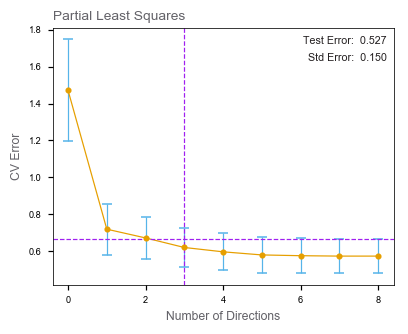

In [24]:
# out cross-validation gives 3 components, but let's pretend
# that the result is n = 2 components to be consistent with the book
ps = PLSRegression(n_components=2, scale=False).fit(X_train, y_train)
# save model parameters as 1D vector
ps_params = np.hstack((ps.y_mean_, np.squeeze(ps.coef_)))
# estimate Test Error and Std Error
ps_error_rate, ps_std_error = assess_selected_model(ps)
# it is not possible to calculate err & std err for n = 0 directions
# so copy it from lasso results, because it corresponds to baseline
n_directions = list(range(0, 9))
# plot results
plot_cv_results('Partial Least Squares', 'Number of Directions',
                ps_error_rate, ps_std_error,
                n_directions, 
                np.hstack((lo_errs[0], ps_errs)), 
                np.hstack((lo_std_errs[0], ps_std_errs)),
                best_err, best_std_err, selected_index+1)

## Best Subset Regression

In [25]:
# PAGE 57. Best subset regression finds for each k ∈ {0, 1, 2,... ,p} the subset of size k
#          that gives smallest residual sum of squares (3.2).
from itertools import combinations

In [26]:
# sklearn doesn't have best subset regression implemented
# here it is implemented as a subclass of linear regression
# so it can be used in standard sklearn pipelines and CV
class BestSubsetRegression(LinearRegression):
    def __init__(self, subset_size=1):
        LinearRegression.__init__(self)
        self.subset_size = subset_size
    def fit(self, X, y, sample_weight=None):
        best_combination, best_mse = None, None
        best_intercept_, best_coef_ = None, None
        # try all combinations of subset_size
        for combination in combinations(range(X.shape[1]), self.subset_size):
            X_tmp = X[:, combination]
            LinearRegression.fit(self, X_tmp, y)
            mse = mean_squared_error(y, self.predict(X_tmp))
            if best_mse is None or best_mse > mse:
                # select the best combination
                best_combination, best_mse = combination, mse
                best_intercept_, best_coef_ = self.intercept_, self.coef_
        LinearRegression.fit(self, X, y)
        # replace intercept and parameters with the found, set other zero
        self.intercept_ = best_intercept_
        self.coef_ = np.zeros(shape=self.coef_.shape)
        for i, idx in enumerate(best_combination):
            self.coef_[0, idx] = best_coef_[0, i]

In [27]:
# it is not possible to use Best Subset with 0 size, so run CV with 1-8 k
parameters = {'subset_size': list(range(1, 9))}
# run CV to chose best parameter
bs_errs, bs_std_errs, best_err, best_std_err, selected_index = \
    do_cross_validation(BestSubsetRegression(), parameters)

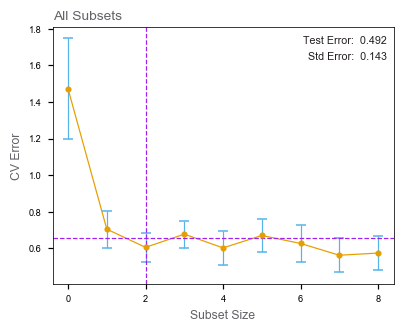

In [28]:
# refit the model to the training set with subset size from CV
bs = BestSubsetRegression(subset_size=parameters['subset_size'][selected_index])
bs.fit(X_train, y_train)
# save model parameters as 1D vector
bs_params = np.hstack((bs.intercept_, np.squeeze(bs.coef_)))
# estimate Test Error and Std Error
bs_error_rate, bs_std_error = assess_selected_model(bs)
# it is not possible to calculate err & std err for k = 0 subset size
# so copy it from lasso results, because it corresponds to baseline
subset_sizes = list(range(0, 9))
# plot results
plot_cv_results('All Subsets', 'Subset Size',
                bs_error_rate, bs_std_error,
                subset_sizes, 
                np.hstack((lo_errs[0], bs_errs)), 
                np.hstack((lo_std_errs[0], bs_std_errs)),
                best_err, best_std_err, selected_index+1)

## Summary (TABLE 3.3)

In [29]:
# PAGE 63. TABLE 3.3. Estimated coefficients and test error results, for different subset
#          and shrinkage methods applied to the prostate date. The blank entries correspond
#          to variables omitted.

# NOTE: The result is very close to the values in the table of the book. However, there are 
#       differences. In most cases, in the second and third decimal places. Perhaps the 
#       implementation of the algorithms in R and sklearn are slightly different. Test errors 
#       and standard test errors are almost identical.
result = zip(['Intercept'] + features, 
             ls_params, bs_params, rd_params, lo_params, pc_params, ps_params)
print('      Term       LS   Best Subset    Ridge    Lasso      PCR      PLS')
print('---------------------------------------------------------------------')
for term, ls, bs, rd, lo, pc, ps in result:
    print(f'{term:>10}{ls:>9.3f}{bs:>14.3f}{rd:>9.3f}{lo:>9.3f}{pc:>9.3f}{ps:>9.3f}')
print('---------------------------------------------------------------------')
print(f'Test Error{ls_error_rate:>9.3f}{bs_error_rate:>14.3f}{rd_error_rate:>9.3f}'
      f'{lo_error_rate:>9.3f}{pc_error_rate:>9.3f}{ps_error_rate:>9.3f}')
print(f' Std Error{ls_std_error:>9.3f}{bs_std_error:>14.3f}{rd_std_error:>9.3f}'
      f'{lo_std_error:>9.3f}{pc_std_error:>9.3f}{ps_std_error:>9.3f}')

      Term       LS   Best Subset    Ridge    Lasso      PCR      PLS
---------------------------------------------------------------------
 Intercept    2.465         2.477    2.464    2.468    2.497    2.452
    lcavol    0.676         0.736    0.405    0.536    0.548    0.417
   lweight    0.262         0.315    0.234    0.187    0.287    0.343
       age   -0.141         0.000   -0.042    0.000   -0.154   -0.026
      lbph    0.209         0.000    0.158    0.000    0.213    0.219
       svi    0.304         0.000    0.221    0.085    0.313    0.242
       lcp   -0.287         0.000    0.010    0.000   -0.062    0.078
   gleason   -0.021         0.000    0.042    0.000    0.226    0.011
     pgg45    0.266         0.000    0.128    0.006   -0.048    0.083
---------------------------------------------------------------------
Test Error    0.521         0.492    0.492    0.479    0.449    0.527
 Std Error    0.179         0.143    0.164    0.164    0.106    0.150
